我先对"Carmon2019Unlabeled"网络进行了标准PGD攻击,     
Accuracy: 89.69%, Robust Accuracy: 62.55%,     
然后组合攻击, 先进行了saturate的corruption, 生成x_cor, 然后对x_cor进行PGD,      
结果为Accuracy: 86.73%(x_cor的acc), Robust Accuracy: 53.58%.      
为了验证组合攻击并非单纯的叠加作用, 而是惯序攻击,     
我进行了先PGD, 后saturate的corruption的攻击,      
结果Accuracy: 89.69%, Robust Accuracy: 66.93%     

In [3]:
import os
import numpy as np
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torch.utils.data import Subset
import torchvision.transforms as transforms
# from torch.nn import Softmax
from robustbench.utils import load_model
root = '/home/.faa'
model_path = os.path.join(root, 'model')
data_path = os.path.join(root, 'data')
model = load_model(model_name='Carmon2019Unlabeled', model_dir=model_path, dataset='cifar10',threat_model='Linf')

def cifar10_data(train, batch_size):
    cifar10 = datasets.CIFAR10(data_path, train=train, transform=transforms.ToTensor())
    loader = DataLoader(cifar10, batch_size=batch_size, shuffle=True,)
    return loader
loader = cifar10_data(False, 128)

In [2]:
import torch.nn as nn
from advertorch.attacks.utils import multiple_mini_batch_attack
from advertorch.attacks import LinfPGDAttack
model = model.cuda()
adversary = LinfPGDAttack(model, nn.CrossEntropyLoss(reduction="sum"), eps=8. / 255,
    nb_iter=20, eps_iter=2. / 255, rand_init=False, clip_min=0.0, clip_max=1.0,
    targeted=False)
label, pred, advpred, _ = multiple_mini_batch_attack(
    adversary, loader, device="cuda")

print("Accuracy: {:.2f}%, Robust Accuracy: {:.2f}%".format(
    100. * (label == pred).sum().item() / len(label),
    100. * (label == advpred).sum().item() / len(label)))

Accuracy: 89.69%, Robust Accuracy: 62.55%


In [28]:
import torch
from advertorch.utils import predict_from_logits
from CorruptionAttacks import ApplyCorruptions
def multiple_mini_batch_attack_with_corruptions(
        adversary, loader, device="cuda", corruption_name=False,
        norm=None, num_batch=None):
    lst_label = []
    lst_pred = []
    lst_advpred = []
    lst_dist = []

    _norm_convert_dict = {"Linf": "inf", "L2": 2, "L1": 1}
    if norm in _norm_convert_dict:
        norm = _norm_convert_dict[norm]

    if norm == "inf":
        def dist_func(x, y):
            return (x - y).view(x.size(0), -1).max(dim=1)[0]
    elif norm == 1 or norm == 2:
        from advertorch.utils import _get_norm_batch

        def dist_func(x, y):
            return _get_norm_batch(x - y, norm)
    else:
        assert norm is None

    idx_batch = 0

    for data, label in loader:
        print(data.shape)
        data, label = data.to(device), label.to(device)
        corruptions = ApplyCorruptions(data, 1, corruption_name)
        adv = adversary.perturb(corruptions, label)
        advpred = predict_from_logits(adversary.predict(adv))
        pred = predict_from_logits(adversary.predict(corruptions))
        lst_label.append(label)
        lst_pred.append(pred)
        lst_advpred.append(advpred)
        if norm is not None:
            lst_dist.append(dist_func(data, adv))

        idx_batch += 1
        if idx_batch == num_batch:
            break

    return torch.cat(lst_label), torch.cat(lst_pred), torch.cat(lst_advpred), \
           torch.cat(lst_dist) if norm is not None else None

In [9]:
import torch.nn as nn
from advertorch.attacks import LinfPGDAttack
model = model.cuda()
adversary = LinfPGDAttack(model, nn.CrossEntropyLoss(reduction="sum"), eps=8. / 255,
    nb_iter=20, eps_iter=2. / 255, rand_init=False, clip_min=0.0, clip_max=1.0,
    targeted=False)
label, pred, advpred, _ = multiple_mini_batch_attack_with_corruptions(
    adversary, loader,device="cuda", corruption_name='saturate')

print("Accuracy: {:.2f}%, Robust Accuracy: {:.2f}%".format(
    100. * (label == pred).sum().item() / len(label),
    100. * (label == advpred).sum().item() / len(label)))

Accuracy: 86.73%, Robust Accuracy: 53.58%


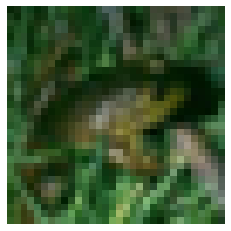

In [15]:
from matplotlib import pyplot as plt
for x, y in loader:
    break
x_ori = x[0].clone().detach()
x_adv = x[0].clone().detach()
x_ori = x_ori.swapaxes(0,1)
x_ori = x_ori.swapaxes(1,2)
# x_ori = (x_ori * 255).astype(np.uint8)
plt.imshow(x_ori) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

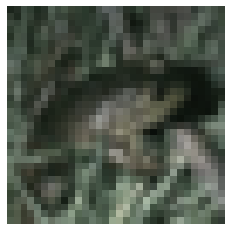

In [16]:
x_adv = x_adv.cpu().numpy()
x_adv = (x_adv * 255).astype(np.uint8)
x_adv = x_adv.swapaxes(0,1)
x_adv = x_adv.swapaxes(1,2)
from imagenet_c import corrupt
corrupt_x = corrupt(x_adv, corruption_name='saturate', severity=int(1))
plt.imshow(corrupt_x) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

In [22]:
x_adv = torch.from_numpy(corrupt_x).float().permute((2,0,1)).cuda()

In [10]:
import torch
from advertorch.utils import predict_from_logits
from CorruptionAttacks import ApplyCorruptions
def multiple_mini_batch_attack_after_corruptions(
        adversary, loader, device="cuda", corruption_name=False,
        norm=None, num_batch=None):
    lst_label = []
    lst_pred = []
    lst_advpred = []
    lst_dist = []

    _norm_convert_dict = {"Linf": "inf", "L2": 2, "L1": 1}
    if norm in _norm_convert_dict:
        norm = _norm_convert_dict[norm]

    if norm == "inf":
        def dist_func(x, y):
            return (x - y).view(x.size(0), -1).max(dim=1)[0]
    elif norm == 1 or norm == 2:
        from advertorch.utils import _get_norm_batch

        def dist_func(x, y):
            return _get_norm_batch(x - y, norm)
    else:
        assert norm is None

    idx_batch = 0

    for data, label in loader:
        data, label = data.to(device), label.to(device)
        adv = adversary.perturb(data, label)
        adv = ApplyCorruptions(adv, 1, corruption_name)
        advpred = predict_from_logits(adversary.predict(adv))
        pred = predict_from_logits(adversary.predict(data))
        lst_label.append(label)
        lst_pred.append(pred)
        lst_advpred.append(advpred)
        if norm is not None:
            lst_dist.append(dist_func(data, adv))

        idx_batch += 1
        if idx_batch == num_batch:
            break

    return torch.cat(lst_label), torch.cat(lst_pred), torch.cat(lst_advpred), \
           torch.cat(lst_dist) if norm is not None else None

In [27]:
import torch.nn as nn
from advertorch.attacks import LinfPGDAttack
model = model.cuda()
adversary = LinfPGDAttack(model, nn.CrossEntropyLoss(reduction="sum"), eps=8. / 255,
    nb_iter=20, eps_iter=2. / 255, rand_init=False, clip_min=0.0, clip_max=1.0,
    targeted=False)
label, pred, advpred, _ = multiple_mini_batch_attack_after_corruptions(
    adversary, loader,device="cuda", corruption_name='saturate')

print("Accuracy: {:.2f}%, Robust Accuracy: {:.2f}%".format(
    100. * (label == pred).sum().item() / len(label),
    100. * (label == advpred).sum().item() / len(label)))

Accuracy: 89.69%, Robust Accuracy: 66.93%


for more attack

In [1]:
op = ['contrast', 'motion_blur', 'zoom_blur', 'spatter', 'pixelate', 'brightness']#'saturate'

In [ ]:
for x, y in loader:
    break

In [12]:
import torch.nn as nn
from advertorch.attacks import LinfPGDAttack
from matplotlib import pyplot as plt
from imagenet_c import corrupt
model = model.cuda()
adversary = LinfPGDAttack(model, nn.CrossEntropyLoss(reduction="sum"), eps=8. / 255,
    nb_iter=20, eps_iter=2. / 255, rand_init=False, clip_min=0.0, clip_max=1.0,
    targeted=False)

for operation in op:
    label, pred, advpred, _ = multiple_mini_batch_attack_with_corruptions(
        adversary, loader,device="cuda", corruption_name=operation)

    print("{}, Accuracy: {:.2f}%, Robust Accuracy: {:.2f}%".format(
        operation, 
        100. * (label == pred).sum().item() / len(label),
        100. * (label == advpred).sum().item() / len(label)))

    x_adv = x.clone().detach()
    x_adv = x_adv.cpu().numpy()
    x_adv = (x_adv * 255).astype(np.uint8)
    x_adv = x_adv.swapaxes(0,1)
    x_adv = x_adv.swapaxes(1,2)
    corrupt_x = corrupt(x_adv, corruption_name='saturate', severity=int(1))
    plt.imshow(corrupt_x) # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()

contrast, Accuracy: 47.54%, Robust Accuracy: 9.10%


AxisError: axis2: axis 2 is out of bounds for array of dimension 2

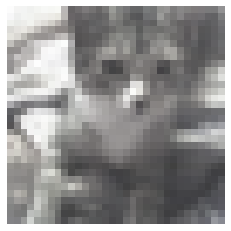

In [21]:
x_adv = x.clone().detach()
x_adv = x_adv.cpu().numpy()
x_adv = (x_adv * 255).astype(np.uint8)
corrupt_x = corrupt(x_adv, corruption_name='saturate', severity=int(1))
plt.imshow(corrupt_x) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

In [ ]:
import torch
from advertorch.utils import predict_from_logits
from CorruptionAttacks import ApplyCorruptions
def multiple_mini_batch_attack_with_corruptions(
        adversary, loader, device="cuda", corruption_name=False,
        norm=None, num_batch=None):
    lst_label = []
    lst_pred = []
    lst_advpred = []
    lst_dist = []

    _norm_convert_dict = {"Linf": "inf", "L2": 2, "L1": 1}
    if norm in _norm_convert_dict:
        norm = _norm_convert_dict[norm]

    if norm == "inf":
        def dist_func(x, y):
            return (x - y).view(x.size(0), -1).max(dim=1)[0]
    elif norm == 1 or norm == 2:
        from advertorch.utils import _get_norm_batch

        def dist_func(x, y):
            return _get_norm_batch(x - y, norm)
    else:
        assert norm is None

    idx_batch = 0

    for data, label in loader:
        data, label = data.to(device), label.to(device)
        corruptions = ApplyCorruptions(data, 1, corruption_name)
        adv = adversary.perturb(corruptions, label)
        advpred = predict_from_logits(adversary.predict(adv))
        pred = predict_from_logits(adversary.predict(corruptions))
        lst_label.append(label)
        lst_pred.append(pred)
        lst_advpred.append(advpred)
        if norm is not None:
            lst_dist.append(dist_func(data, adv))

        idx_batch += 1
        if idx_batch == num_batch:
            break

    return torch.cat(lst_label), torch.cat(lst_pred), torch.cat(lst_advpred), \
           torch.cat(lst_dist) if norm is not None else None

In [31]:
import torch.nn as nn
from advertorch.attacks import LinfPGDAttack
from matplotlib import pyplot as plt
from imagenet_c import corrupt

op = ['motion_blur', 'zoom_blur', 'spatter', 'pixelate', 'brightness']#'saturate'
model = model.cuda()
loader = cifar10_data(False, 128)
adversary = LinfPGDAttack(model, nn.CrossEntropyLoss(reduction="sum"), eps=8. / 255,
    nb_iter=20, eps_iter=2. / 255, rand_init=False, clip_min=0.0, clip_max=1.0,
    targeted=False)

for operation in op:
    label, pred, advpred, _ = multiple_mini_batch_attack_with_corruptions(
        adversary, loader, device="cuda", corruption_name=operation)

    print("{}, Accuracy: {:.2f}%, Robust Accuracy: {:.2f}%".format(
        operation, 
        100. * (label == pred).sum().item() / len(label),
        100. * (label == advpred).sum().item() / len(label)))


torch.Size([128, 3, 32, 32])


RuntimeError: number of dims don't match in permute